## Multilingual NLP with mBERT
The BERT model, and by extension mBERT (multilingual BERT), is a transformer-based model.  
It uses a multi-layer bidirectional transformer architecture to process text.  
The model is pre-trained on a large corpus of text in multiple languages using a masked language modeling (MLM) objective.  
This enables the model to capture contextual information across different languages.

In [1]:
!pip install datasets
!pip install transformers
!pip install torch
!pip install ipywidgets
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 15.6 MB/s eta 0:00:0000:0100:01


In [2]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification, pipeline
from datasets import load_dataset
import torch
import pandas as pd

2024-08-15 14:22:48.049129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 14:22:48.063991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 14:22:48.068579: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 14:22:48.079523: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 14:22:48.827396: W tensorflow/compiler/tf2

## 1. Multilingual Masked Language Modeling  
- 다른 언어간 문장을 합쳐 Input 전달

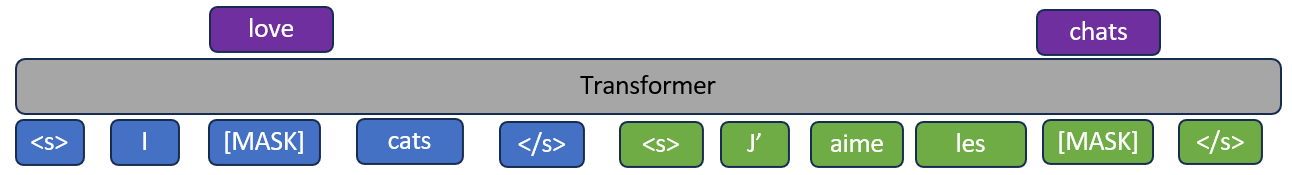

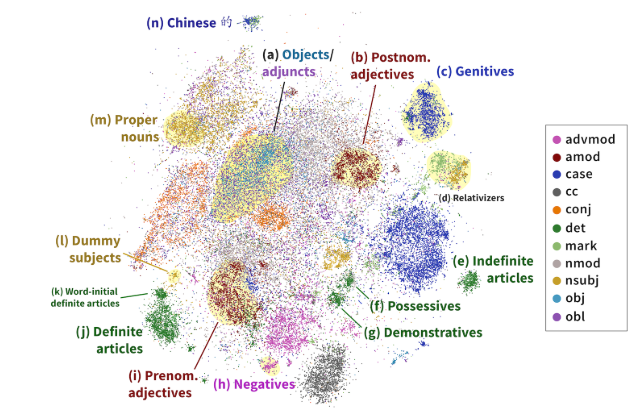

비슷한 역할을 하거나 의미가 유사한 단어들은 가까운 공간에 존재

In [3]:
# Cross-lingual MLM with Pretrained mBERT
# Load the pretrained mBERT model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)


/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internall

In [4]:
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [5]:
# Function to perform MLM
def cross_lingual_mlm(text):
    inputs = tokenizer(text, return_tensors="pt")
    masked_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1].tolist()[0]
    # mask된 위치를 찾는 code

    with torch.no_grad():
        outputs = model(**inputs)
        
    logits = outputs.logits

    masked_token_logits = logits[0, masked_index] # size: output_dim

    predicted_token_id = torch.argmax(masked_token_logits).item()
    predicted_token = tokenizer.decode([predicted_token_id])
    
    return predicted_token, masked_token_logits

In [6]:
# Example usage
text = "Question: 물은 가져 왔니? Answer: No, I forgot to bring [MASK]."
predicted_token, masked_token_logits = cross_lingual_mlm(text)

In [7]:
print(predicted_token)
print(masked_token_logits.shape) # multi lingual 단어들의 logit

water
torch.Size([119547])


In [8]:
# DIY: print top-10 probability

# logits to probability (hint: apply torch.softmax to dimesion 0)
# Your Code Here
masked_token_probs = torch.softmax(masked_token_logits, dim=0)

# take the idx of top-10 probs
# Your Code Here
top_indexs = torch.topk(masked_token_logits, k=10, dim=0).indices.tolist()

# print top-10 tokens with corresponding probs
# Your Code Here
tok_10_tokens = [tokenizer.decode([idx]) for idx in top_indexs]
tok_10_prob = [masked_token_probs[idx] for idx in top_indexs]

for token, prob in zip(tok_10_tokens, tok_10_prob):
    print(f"{token}: {prob:.4f}")

print(f"\nOriginal text: {text}")
print(f"Predicted text: {text.replace('[MASK]', predicted_token)}")

water: 0.2579
it: 0.0702
milk: 0.0431
them: 0.0310
back: 0.0220
us: 0.0205
in: 0.0200
anything: 0.0176
over: 0.0154
you: 0.0142

Original text: Question: 물은 가져 왔니? Answer: No, I forgot to bring [MASK].
Predicted text: Question: 물은 가져 왔니? Answer: No, I forgot to bring water.


## 2. Multilingual Sentiment Analysis with Fine-tuned mBERT


In [9]:
# Load fine-tuned mBERT for sentiment analysis
sentiment_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
sentiment_pipeline = pipeline("sentiment-analysis", model=sentiment_model_name, tokenizer=sentiment_model_name)

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [10]:
# Show model architecture
sentiment_model = sentiment_pipeline.model
print(sentiment_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [11]:
# Example usage
texts = ["I love this product!", "Je déteste ce produit.", "Este producto es terrible."]
sentiments = sentiment_pipeline(texts)
for text, sentiment in zip(texts, sentiments):
    print(f"Text: {text}\nSentiment: {sentiment}\n")

Text: I love this product!
Sentiment: {'label': '5 stars', 'score': 0.9135048389434814}

Text: Je déteste ce produit.
Sentiment: {'label': '1 star', 'score': 0.6797647476196289}

Text: Este producto es terrible.
Sentiment: {'label': '1 star', 'score': 0.9237270951271057}



## 3. Cross-lingual Information Retrieval with mBERT

In [24]:
# Cross-lingual Information Retrieval with mBERT
# Load dataset for IR demonstration
from transformers import AutoTokenizer, AutoModel

# Load pre-trained mBERT model and tokenizer
model_name = "bert-base-multilingual-cased"  # Choose a suitable multilingual model -> dense한 모델
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [16]:
!wget -O ./amazon_review_compact.csv https://drive.google.com/uc?id=1tvTWXLFOYu2WGtIyRiR7aBP-gbbxY5kF

--2024-08-15 14:25:57--  https://drive.google.com/uc?id=1tvTWXLFOYu2WGtIyRiR7aBP-gbbxY5kF
Resolving drive.google.com (drive.google.com)... 142.250.206.206, 2404:6800:4004:818::200e
Connecting to drive.google.com (drive.google.com)|142.250.206.206|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1tvTWXLFOYu2WGtIyRiR7aBP-gbbxY5kF [following]
--2024-08-15 14:25:57--  https://drive.usercontent.google.com/download?id=1tvTWXLFOYu2WGtIyRiR7aBP-gbbxY5kF
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.76.129, 2404:6800:400a:80b::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.76.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 952649 (930K) [application/octet-stream]
Saving to: ‘./amazon_review_compact.csv’

./amazon_review_com 100%[===================>] 930.32K  5.28MB/s    in 0.2s    

2024-08-15 14:26:00 (5.28 

In [17]:
import pandas as pd
import torch

# Load the dataset
dataset = pd.read_csv('./amazon_review_compact.csv')
DataSize = 3200
dataset = dataset.head(DataSize)
dataset.head()

,sentiment,title
0,2.0,Great CD
1,2.0,One of the best game music soundtracks - for a...
2,1.0,Batteries died within a year ...
3,2.0,"works fine, but Maha Energy is better"
4,2.0,Great for the non-audiophile


In [18]:
dataset["title"]

0                                                Great CD
1       One of the best game music soundtracks - for a...
2                        Batteries died within a year ...
3                   works fine, but Maha Energy is better
4                            Great for the non-audiophile
                              ...                        
3195                                          GREAT MOVIE
3196    Contrived and so far from what we know about J...
3197                               one word: unbelievable
3198                                         Greaat Movie
3199                                    My Son's FAvorite
Name: title, Length: 3200, dtype: object

In [28]:
# Function to perform cross-lingual IR
def cross_lingual_ir(query, dataset, top_k=3, bsz=32):
    query_embedding = model(**tokenizer(query, return_tensors="pt").to(device))["last_hidden_state"].mean(dim=1)
    # 마지막 레이어 구조 : Linear(in_features=768, out_features=768, bias=True)
    similarities = []

    for i in range(0, len(dataset), bsz):
        batch = dataset.iloc[i:i+bsz,1]

        # Print progress
        if (i//bsz) % 10 == 0:
            print(f"Batch {i//bsz} of {len(dataset)//bsz}")

        # Convert the Pandas Series to a list of strings explicitly
        batch_text = batch.astype(str).tolist()  # Ensure each element is treated as a string

        # get batch embedding
        batch_embedding = model(**tokenizer(batch_text, return_tensors="pt", padding=True).to(device))["last_hidden_state"].mean(dim=1)
        # calculate cosine similarity
        similarities.extend(torch.cosine_similarity(query_embedding, batch_embedding, dim=1).tolist())

    top_indices = torch.argsort(torch.tensor(similarities))[-top_k:].numpy() # Convert to numpy array and extract indices
    return [(dataset.iloc[idx, 1], similarities[idx]) for idx in top_indices]

In [29]:
# Example usage
query = "재미없는 영화였습니다."
results = cross_lingual_ir(query, dataset)
print(f"Query: {query}")
for result in results:
  print(f"Context: {result[0]}\nSimilarity: {result[1]}\n")

Batch 0 of 100
Batch 10 of 100
Batch 20 of 100
Batch 30 of 100
Batch 40 of 100
Batch 50 of 100
Batch 60 of 100
Batch 70 of 100
Batch 80 of 100
Batch 90 of 100
Query: 재미없는 영화였습니다.
Context: Makes Hellboy look like a masterpiece.
Similarity: 0.5280160903930664

Context: This is a horrible, horrible movie.
Similarity: 0.5414084196090698

Context: What started out to be a beautiful movie....thrown in the trash!
Similarity: 0.5477674007415771



#### Appendix. faiss로 similarity 구현

In [32]:
import faiss
import numpy as np

def normalize(vectors):
    norms = np.linalg.norm(vectors, axis=1, keepdims=True)
    return vectors / norms

def cross_lingual_ir_faiss(dataset, bsz=32):
    similarities = []

    for i in range(0, len(dataset), bsz):
        batch = dataset.iloc[i:i+bsz,1]

        if (i//bsz) % 10 == 0:
            print(f"Batch {i//bsz} of {len(dataset)//bsz}")

        batch_text = batch.astype(str).tolist()

        batch_embedding = model(**tokenizer(batch_text, return_tensors="pt", padding=True).to(device))["last_hidden_state"].mean(dim=1)
        # calculate cosine similarity
        similarities.extend(batch_embedding.tolist())
    
    # faiss 변환, faiss 기본 데이터 형태 -> numpy
    similarities = normalize(np.array(similarities, dtype=np.float32))
    faissDB = faiss.IndexFlatIP(768)
    faissDB.add(similarities)

    return faissDB

In [33]:
# create faissDB
faissDB = cross_lingual_ir_faiss(dataset)

Batch 0 of 100
Batch 10 of 100
Batch 20 of 100
Batch 30 of 100
Batch 40 of 100
Batch 50 of 100
Batch 60 of 100
Batch 70 of 100
Batch 80 of 100
Batch 90 of 100


In [39]:
query = "정말 놀라운 영화였습니다."
#query_embedding = normalize(model(**tokenizer(query, return_tensors="pt").to(device))["last_hidden_state"].mean(dim=1).detach().numpy())
# Tokenize and move to device
query_embedding_tensor = model(**tokenizer(query, return_tensors="pt").to(device))["last_hidden_state"].mean(dim=1)
# Move tensor to CPU and convert to numpy array
query_embedding = normalize(query_embedding_tensor.cpu().detach().numpy())


distances, indices = faissDB.search(query_embedding, 4)

print(f"Query: {query}")

for distance, idx in zip(distances[0], indices[0]):
  print(f"Context: {dataset.iloc[idx, 1]}\nSimilarity: {distance}\n")

# 감정분석이 제대로 안되는 이유 : .mean(dim=1).detach().numpy()으로 문장 자체의 벡터 평균을 내서 오차가 심함

Query: 정말 놀라운 영화였습니다.
Context: This is a horrible, horrible movie.
Similarity: 0.5954431295394897

Context: This should have been a good movie...
Similarity: 0.5703092813491821

Context: Possibly the funniest movie ever made.
Similarity: 0.5636405944824219

Context: What started out to be a beautiful movie....thrown in the trash!
Similarity: 0.5589898228645325



## 4. Multimodality (CLIP)

CLIP consists of two main components:

An image encoder: A Vision Transformer (ViT) that converts images into embeddings.
A text encoder: A Transformer model that converts text into embeddings.
These two encoders are trained jointly to ensure that the embeddings from both modalities are comparable, allowing for tasks like image-text similarity and zero-shot classification.

####  Vision Transformer (ViT) Architecture
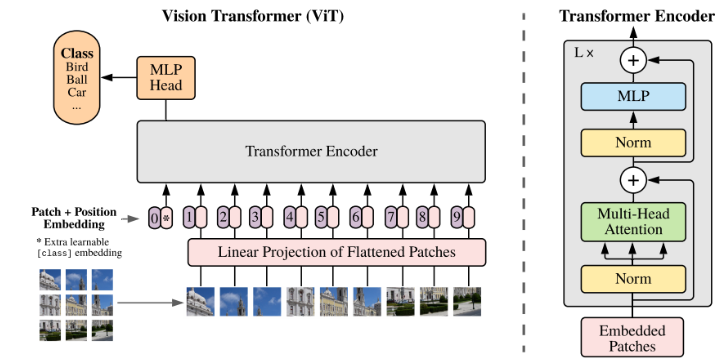

#### Contrastive Language-Image Pretraining (CLIP)

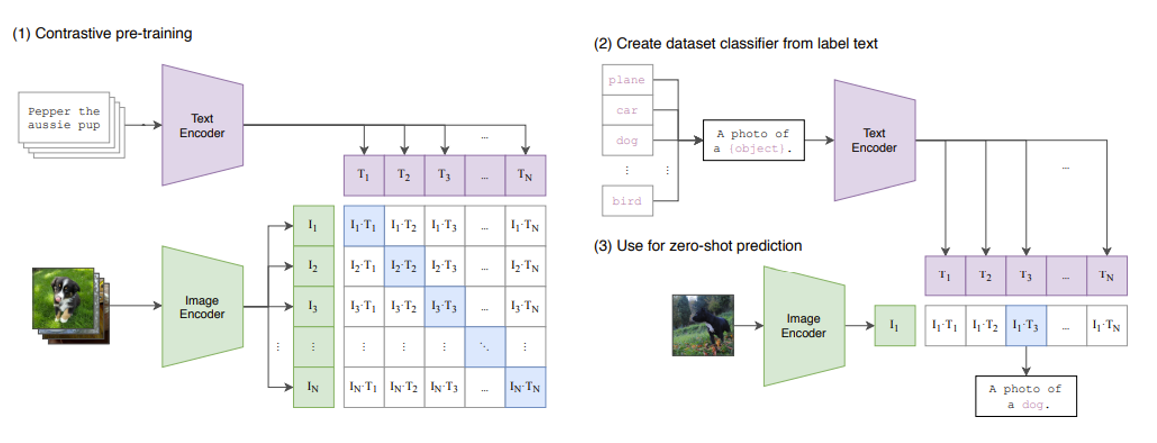

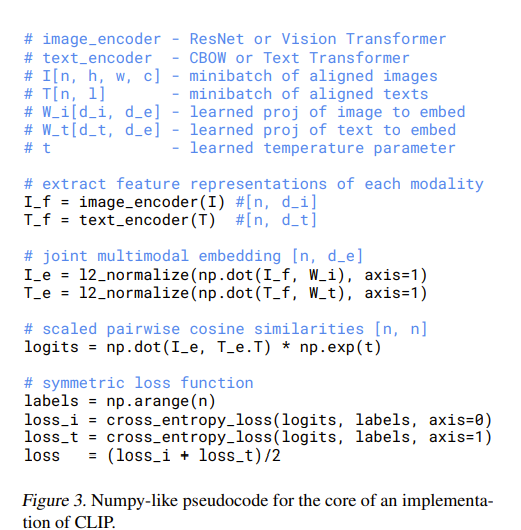

In [40]:
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import requests
from io import BytesIO

# Load the model and processor
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/home/devrok/.conda/envs/nlp_pt/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [41]:
# model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# show model architecture
print(model)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

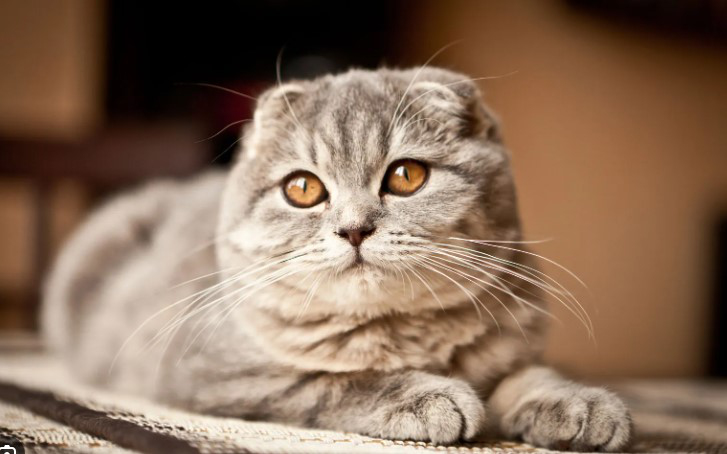

In [46]:
# show images
Image.open("./image_0.jpg")

In [49]:
# Load image as an object
image = Image.open("./image_0.jpg")

# Define possible labels
labels = ["a dog", "a cat", "a person", "a car", "a kitten"]

# Preprocess the inputs
inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)
# Move inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get the image and text features
outputs = model(**inputs)

# Compute logits
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
print(logits_per_image.shape)

torch.Size([1, 5])


In [50]:
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

# Print the results
for i, label in enumerate(labels):
    print(f"Label: {label}, Probability: {probs[0][i].item():.4f}")

Label: a dog, Probability: 0.0027
Label: a cat, Probability: 0.7827
Label: a person, Probability: 0.0018
Label: a car, Probability: 0.0004
Label: a kitten, Probability: 0.2123


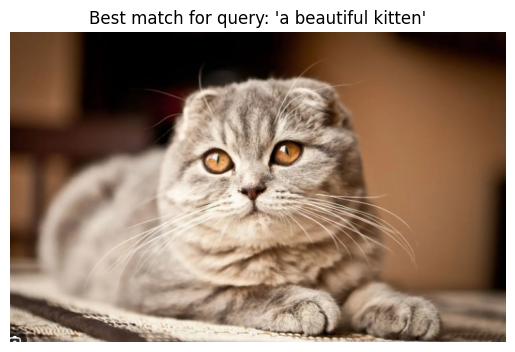

In [53]:
import matplotlib.pyplot as plt

# Load multiple images
images = [Image.open(f"./image_{i}.jpg") for i in range(3)]

# Define the query text
query = "a beautiful kitten"

# Preprocess the inputs
inputs = processor(text=[query], images=images, return_tensors="pt", padding=True)
# Move inputs to the same device as the model
inputs = {k: v.to(device) for k, v in inputs.items()}

# Get the image and text features
outputs = model(**inputs)

# Compute logits
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=0) # we can take the softmax to get the label probabilities

# Find the best matching image
best_match_idx = probs.argmax()

# Display the best matching image
best_match_image = images[best_match_idx]

plt.imshow(best_match_image)
plt.title(f"Best match for query: '{query}'")
plt.axis('off')
plt.show()

## Advanced Materials

### Huggingface Implementation

Transformers: https://github.com/huggingface/transformers/tree/main/src/transformers/models  
    (HuggingFace Transfomer Model library code)

### Selected Papers

*  "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" (BERT, 2017): https://arxiv.org/abs/1810.04805
*   "XTREME: A Massively Multilingual Multi-task Benchmark
for Evaluating Cross-lingual Generalization (2020)": https://arxiv.org/abs/2003.11080
*  "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" (Vision Transformer, 2020): https://arxiv.org/abs/2010.11929
*   "Learning Transferable Visual Models From Natural Language Supervision" (CLIP, 2021): https://arxiv.org/abs/2103.00020
*   "BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation" (BLIP, 2022): https://arxiv.org/abs/2201.12086
*    "BLIP-2: Bootstrapping Language-Image Pre-training with Frozen Image Encoders and Large Language Models" (BLIP-2, 2023): https://arxiv.org/abs/2301.12597
*   "Visual Instruction Tuning" (LLaVa, 2023): https://arxiv.org/abs/2304.08485

